In [24]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

In [13]:
#Enable Memory Growth: This ensures that TensorFlow dynamically allocates memory on the GPU as needed, rather than pre-allocating all the memory at once.
# Enable memory growth for the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
# Define the paths to the CASIA dataset
dataset_path = "C:\\Users\\rohan\\OneDrive\\Desktop\\CASIA2"
authentic_path = os.path.join(dataset_path, 'Au')
forged_path = os.path.join(dataset_path, 'Tp')

In [6]:
## from google.colab import drive
## drive.mount('/content/drive')

In [14]:
# Function to load images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize images to a fixed size
            images.append(img)
            labels.append(label)
    return images, labels

In [15]:
# Load authentic and forged images
authentic_images, authentic_labels = load_images_from_folder(authentic_path, 0)
forged_images, forged_labels = load_images_from_folder(forged_path, 1)

# Combine and convert to numpy arrays
images = np.array(authentic_images + forged_images)
labels = np.array(authentic_labels + forged_labels)

# Normalize images and convert to float16 to reduce memory usage
images = images.astype('float16') / 255.0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')

Training samples: 10091, Testing samples: 2523


In [22]:
# Data augmentation
datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=16, subset='training')
validation_generator = datagen.flow(X_train, y_train, batch_size=16, subset='validation')

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [25]:

# Build the improved CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', dtype='float32')  # Binary classification (authentic or forged)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Clear previous session and collect garbage
tf.keras.backend.clear_session()
gc.collect()

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                        

In [26]:
# Train the model with the data generator and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

# Save the model
model.save('C:\\Users\\rohan\\OneDrive\\Documents\\DIP\\dip.keras')

Epoch 1/50
505/505 [==============================] - 29s 54ms/step - loss: 1.1082 - accuracy: 0.5739 - val_loss: 0.7419 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 2/50
505/505 [==============================] - 27s 53ms/step - loss: 0.7014 - accuracy: 0.5988 - val_loss: 0.6982 - val_accuracy: 0.5892 - lr: 0.0010
Epoch 3/50
505/505 [==============================] - 27s 53ms/step - loss: 0.6807 - accuracy: 0.5894 - val_loss: 0.6702 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 4/50
505/505 [==============================] - 28s 55ms/step - loss: 0.6713 - accuracy: 0.5933 - val_loss: 0.6466 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 5/50
505/505 [==============================] - 27s 53ms/step - loss: 0.6786 - accuracy: 0.5953 - val_loss: 0.6772 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 6/50
505/505 [==============================] - 33s 66ms/step - loss: 0.6706 - accuracy: 0.5914 - val_loss: 0.6649 - val_accuracy: 0.5877 - lr: 0.0010
Epoch 7/50
505/505 [==============================] - 35s 

In [27]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

79/79 [==============================] - 2s 18ms/step - loss: 0.5162 - accuracy: 0.7368
Test Loss: 0.5161631107330322, Test Accuracy: 0.7368212342262268


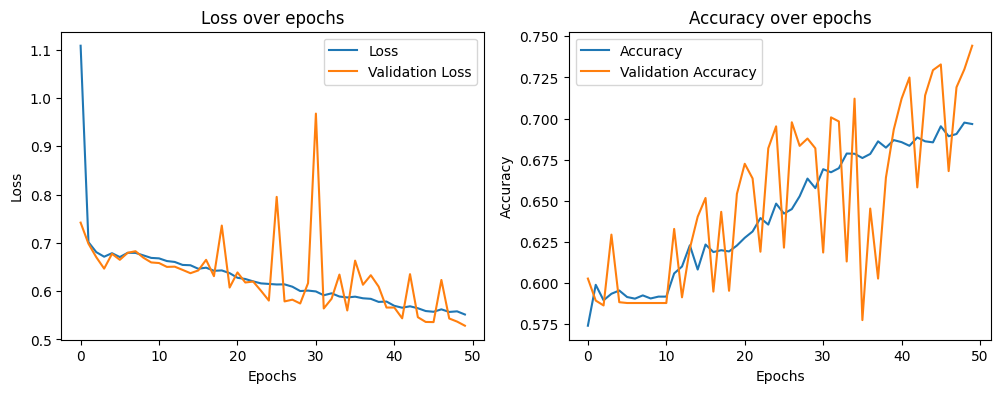

In [28]:
# Plot training history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()